# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
accelerate                            1.5.2
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.23
albumentations                        2.0.5
ale-py                                0.10.2
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.1
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.7.0.35.30
astunparse                            1.6.3
atpublic                              5.1

In [ ]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [69]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [71]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [72]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [73]:
import gdown

In [74]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [75]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [76]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [77]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [78]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [79]:
char_to_num(['k','i','n','i'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([11,  9, 14,  9])>

In [80]:
num_to_char([11,  9,  14, 9])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'k', b'i', b'n', b'i'], dtype=object)>

In [81]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [82]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('/content/drive/MyDrive/','data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('/content/drive/MyDrive/','data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [83]:
test_path = '/content/drive/MyDrive/data/s1/bbaf3s.mpg'

In [84]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf3s'

In [85]:
load_data(tf.convert_to_tensor(test_path))

(<tf.Tensor: shape=(75, 46, 140, 1), dtype=float32, numpy=
 array([[[[1.5611308 ],
          [1.5611308 ],
          [1.5983006 ],
          ...,
          [0.5575467 ],
          [0.5203769 ],
          [0.48320714]],
 
         [[1.5611308 ],
          [1.5611308 ],
          [1.5983006 ],
          ...,
          [0.5575467 ],
          [0.5203769 ],
          [0.48320714]],
 
         [[1.4867913 ],
          [1.4867913 ],
          [1.4867913 ],
          ...,
          [0.48320714],
          [0.48320714],
          [0.48320714]],
 
         ...,
 
         [[1.189433  ],
          [1.189433  ],
          [1.1522632 ],
          ...,
          [0.26018846],
          [0.22301868],
          [0.22301868]],
 
         [[1.189433  ],
          [1.189433  ],
          [1.1522632 ],
          ...,
          [0.22301868],
          [0.1858489 ],
          [0.1858489 ]],
 
         [[1.189433  ],
          [1.189433  ],
          [1.1522632 ],
          ...,
          [0.22301868],
    

In [86]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

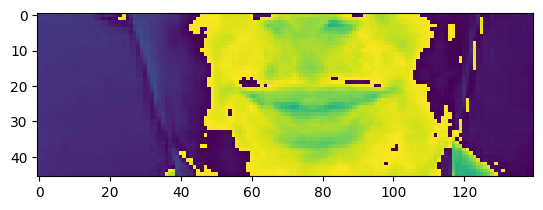

In [87]:
plt.imshow(frames[45])

In [88]:
alignments

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20,  8, 18,
        5,  5, 39, 19, 15, 15, 14])>

In [89]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'h', 'r', 'e', 'e', ' ', 's', 'o', 'o', 'n']


In [90]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f three soon'>

In [91]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [92]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [93]:
frames, alignments = data.as_numpy_iterator().next()

In [94]:
len(test)

50

In [95]:
len(frames)

2

In [96]:
sample = data.as_numpy_iterator()

In [97]:
val = sample.next(); val[0]

array([[[[[ 1.2829633 ],
          [ 1.2829633 ],
          [ 1.2829633 ],
          ...,
          [ 0.18867107],
          [ 0.2641395 ],
          [ 0.18867107]],

         [[ 1.2829633 ],
          [ 1.2829633 ],
          [ 1.2829633 ],
          ...,
          [ 0.11320264],
          [ 0.22640528],
          [ 0.18867107]],

         [[ 1.2829633 ],
          [ 1.2829633 ],
          [ 1.2829633 ],
          ...,
          [ 0.22640528],
          [ 0.11320264],
          [ 0.11320264]],

         ...,

         [[ 0.9056211 ],
          [ 0.9056211 ],
          [ 0.9056211 ],
          ...,
          [ 9.509022  ],
          [ 9.509022  ],
          [ 9.509022  ]],

         [[ 0.9056211 ],
          [ 0.9056211 ],
          [ 0.9056211 ],
          ...,
          [ 9.433554  ],
          [ 9.433554  ],
          [ 9.433554  ]],

         [[ 0.9056211 ],
          [ 0.9056211 ],
          [ 0.9056211 ],
          ...,
          [ 9.433554  ],
          [ 9.433554  ],
          

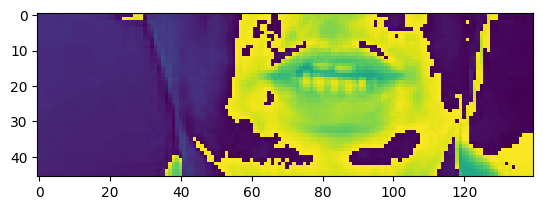

In [98]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [99]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set white at o four now'>

# 3. Design the Deep Neural Network

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [101]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [132]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [103]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
5*17*75

6375

In [105]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


In [106]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'annnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'>

In [107]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'annnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'>

In [108]:
model.input_shape

(None, 75, 46, 140, 1)

In [109]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [133]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [134]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [135]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        input_len = tf.ones(shape=(yhat.shape[0],)) * yhat.shape[1]
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=tf.cast(input_len, dtype='int64'), greedy=True)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [136]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [114]:
checkpoint_callback = ModelCheckpoint(os.path.join('models', 'checkpoint.weights.h5'),
                                      monitor='loss',
                                      save_weights_only=True)


In [115]:
schedule_callback = LearningRateScheduler(scheduler)

In [116]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 100.8341

# 5. Make a Prediction

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=a5c1ebe2-f358-49df-9c22-42bf73cf1cd9
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 120MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [137]:
model.load_weights('/content/converted_weights.h5')

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
test_data = test.as_numpy_iterator()

In [119]:
sample = test_data.next()

In [138]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step


In [139]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white by h zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at x eight now'>]

In [140]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [141]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin white by h zero please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'lay blue at x eight now'>]

# Test on a Video

In [131]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/alignments/s1/.align'

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 720ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]